In [295]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import fmplib as fmp
import glob
import csv
import crepe
from scipy.io import wavfile
from hmmlearn import hmm
import soundfile


## Part 1: Train and test the Hidden Markov Model

Step 1. Import and process lead sheet data.

In [91]:
def process_csv(filename):
    """
    Process a csv file of a lead sheet into a dictionary of measures with note and duration information.
    """
    song_data = {} #key on measure to duration, chord, notes with durations
    with open(filename, mode ='r') as file:
        f = csv.reader(file)
        i = 0
        for line in f:
            if i == 0:
                i += 1
                continue

            _, measure, _, _, chord_root, chord_type, note_root, _, note_duration = tuple(line)
            try:
                measure = int(measure)
            except:
                continue

            # simplify chord
            if chord_type == '[]':
                continue
            elif 'min' in chord_type or 'dim' in chord_type:
                chord = (chord_root, 'minor')
            else:
                chord = (chord_root, 'major')

            # simplify note
            if note_root == 'rest':
                continue
            else:
                note = (note_root, note_duration)

            if measure not in song_data:
                song_data[measure] = {}
                song_data[measure]['duration'] = 0
                song_data[measure]['chord'] = chord
                song_data[measure]['notes'] = []

            song_data[measure]['duration'] += float(note_duration)
            song_data[measure]['notes'].append(note)
    return song_data

train_songs = {}
train_files = glob.glob('dataset/csv_train/*.csv')

for f in train_files:
    name = f.split('/')[-1].split('.')[0]
    song = process_csv(f)
    train_songs[name] = song

test_songs = {}
test_files = glob.glob('dataset/csv_test/*.csv')

for f in test_files:
    name = f.split('/')[-1].split('.')[0]
    song = process_csv(f)
    test_songs[name] = song


In [92]:
print(f'Number of training songs: {len(train_songs)}')
print(f'Number of testing songs: {len(test_songs)}')


Number of training songs: 1802
Number of testing songs: 450


Step 2. Load helper methods notes and chord qualities as numbers.

In [93]:
NOTE_TO_INDEX = {'C': 0, 'D': 2, 'E': 4, 'F': 5, 'G': 7, 'A': 9, 'B': 11}

def note_to_idx(note):
    idx = NOTE_TO_INDEX[note[0]]

    if len(note) == 2:
        if note[1] == '#':
            idx += 1
        elif note[1] == 'b':
            idx -= 1

    return idx % 12

def chord_to_idx(chord):
    root, quality = chord
    idx = note_to_idx(root)

    if quality == 'minor':
        idx += 12
    return int(idx)


Step  3. Create chord templates with harmonics for template-based matching.

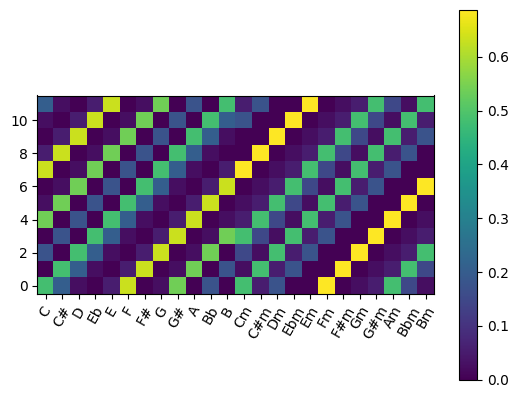

In [94]:
chord_templates = fmp.make_triads_templates(0.7)

plt.imshow(chord_templates.T, origin='lower')
plt.colorbar()
plt.xticks(rotation=60)
fmp.chord_template_labels(1)


Step 4. Estimate the emission probability matrix from the training set. 
- Version 0: 24 x 24 matrix created by fmp.make_emission_prob(alpha) where alpha = 0.7
- Version 1: 24 x 24 matrix for major/minor chords of 12 semitones. Observation is determined per measure by a chroma vector in which each note is weighted by duration. The resulting matrix is combined with a template-based matrix with diagonal ratio of 0.7
- Version 2: Similar to version 1, but considers each observation relative to the state since the dataset is skewed toward C. The same values are then duplicated 12 times. It also gives less weight to the template-based matrix.
- Version 3: 24 x 576 matrix that considers observations as the previous chord and then the current chord, still corresponding to the 24 discrete states.

In [95]:
test_array = np.zeros((24, 24))
test_array[0, 0] = 1
for i in range(1, 12):
    test_array[i, :] = np.roll(test_array[0, :], i)
    # print(test_array[i, :])


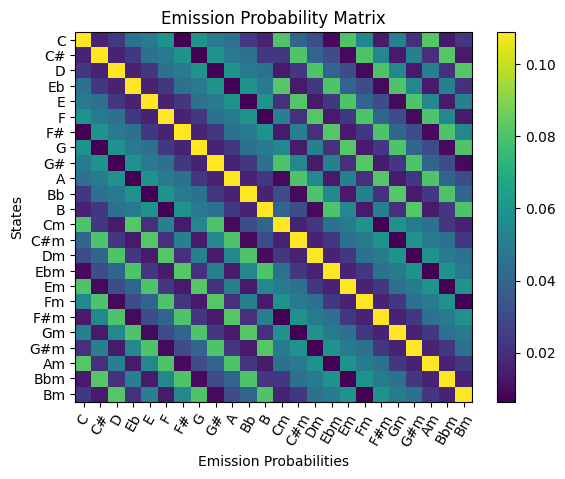

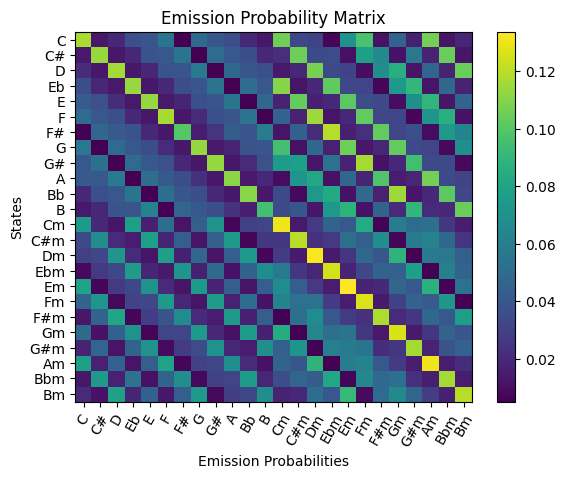

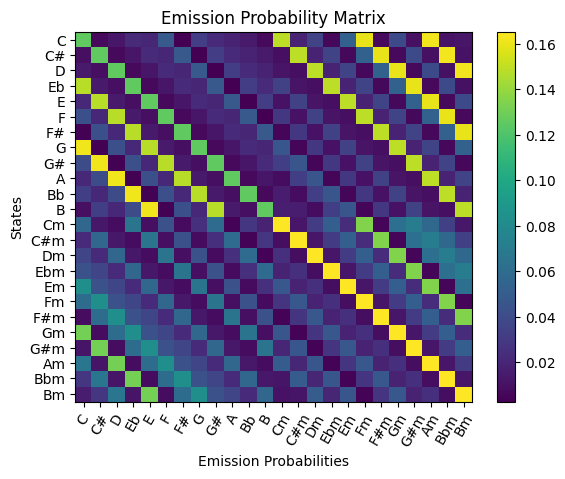

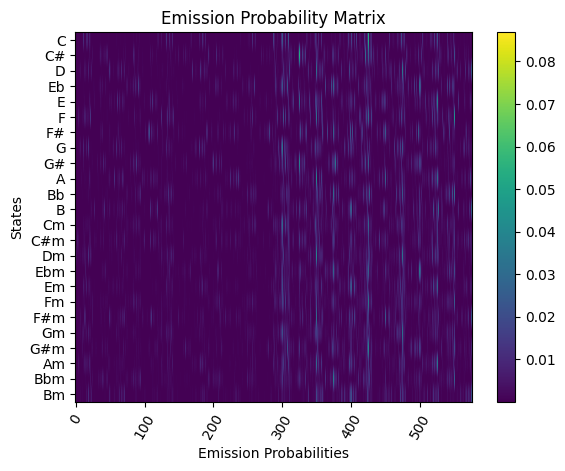

In [393]:
def make_emission_prob_v0():
    B = fmp.make_emission_prob(0.7)

     # plot
    plt.figure()
    plt.imshow(B, aspect='auto')
    plt.title("Emission Probability Matrix")
    fmp.chord_template_labels(0)
    fmp.chord_template_labels(1)
    plt.xticks(rotation = 60)
    plt.xlabel("Emission Probabilities")
    plt.ylabel("States")
    plt.colorbar()
    plt.show()

    return B

def make_emission_prob_v1():
    B = np.zeros((24, 24))
    for i in range(24):
        B[i, i] = 1

    for song in train_songs:
        # create chroma vector where each note is weighted by duration
        for measure in train_songs[song]:
            note = np.zeros(12)
            for n in train_songs[song][measure]['notes']:
                root, dur = n
                note[note_to_idx(root)] += float(dur)**2
            # compare to chord templates to identify which chord it is
            obs = np.argmax(np.dot(chord_templates, note.T))
            state = chord_to_idx(train_songs[song][measure]['chord'])
            # add to emission probability matrix
            B[state, obs] += 1

    # normalize
    norm = np.linalg.norm(B, ord=1, axis=1, keepdims=True)
    B = B / norm

    # weighted average with template-based matrix
    template_weight = 0.8
    B_template_based = fmp.make_emission_prob(0.7)
    B = template_weight * B_template_based + (1 - template_weight) * B

    # plot
    plt.figure()
    plt.imshow(B, aspect='auto')
    plt.title("Emission Probability Matrix")
    fmp.chord_template_labels(0)
    fmp.chord_template_labels(1)
    plt.xticks(rotation = 60)
    plt.xlabel("Emission Probabilities")
    plt.ylabel("States")
    plt.colorbar()
    plt.show()

    return B

def make_emission_prob_v2():

    B = np.zeros((24, 24))
    for i in range(24):
        B[i, i] = 1

    for song in train_songs:
        # create note vector where each note is weighted by duration
        for measure in train_songs[song]:
            note = np.zeros(12)
            for n in train_songs[song][measure]['notes']:
                root, dur = n
                note[note_to_idx(root)] += float(dur)**2
            # compare to chord templates to identify which chord it is
            obs = np.argmax(np.dot(chord_templates, note.T))
            state = chord_to_idx(train_songs[song][measure]['chord'])

            shift = state % 12
            if obs < 12:
                rel_obs = (obs - shift) % 12
            else:
                rel_obs = (obs - shift) % 12 + 12

            # add to emission probability matrix
            if state < 12:
                B[0, rel_obs] += 1
            else:
                B[12, rel_obs] += 1

    for i in range(1, 12):
        B[i, :] = np.roll(B[0, :], i)

    for i in range(12, 24):
        B[i, :] = np.roll(B[12, :], i-12)

    # normalize
    norm = np.linalg.norm(B, ord=1, axis=1, keepdims=True)
    B = B / norm

    # weighted average with template-based matrix
    template_weight = 0.4
    B_template_based = fmp.make_emission_prob(0.7)
    B = template_weight * B_template_based + (1 - template_weight) * B

    # plot
    plt.figure()
    plt.imshow(B, aspect='auto')
    plt.title("Emission Probability Matrix")
    fmp.chord_template_labels(0)
    fmp.chord_template_labels(1)
    plt.xticks(rotation = 60)
    plt.xlabel("Emission Probabilities")
    plt.ylabel("States")
    plt.colorbar()
    plt.show()

    return B

def observation_tuple_to_idx(obs_tuple):
    return obs_tuple[0] * 24 + obs_tuple[1]

def make_emission_prob_v3():

    B = np.ones((24, 576))

    observations = []
    states = []

    for song in train_songs:
        # create note vector where each note is weighted by duration
        for measure in train_songs[song]:
            note = np.zeros(12)
            for n in train_songs[song][measure]['notes']:
                root, dur = n
                note[note_to_idx(root)] += float(dur)**2
            # compare to chord templates to identify which chord it is
            obs = np.argmax(np.dot(chord_templates, note.T))
            state = chord_to_idx(train_songs[song][measure]['chord'])

            observations.append(obs)
            states.append(state)

        for i in range(len(observations)):
            if i == 0:
                prev = observations[i]
            else:
                prev = observations[i-1]
            idx = observation_tuple_to_idx((prev, observations[i]))
            B[states[i], idx] += 1

    # normalize
    norm = np.linalg.norm(B, ord=1, axis=1, keepdims=True)
    B = B / norm

    # plot
    plt.figure()
    plt.imshow(B, aspect='auto')
    plt.title("Emission Probability Matrix")
    fmp.chord_template_labels(0)
    # fmp.chord_template_labels(1)
    plt.xticks(rotation = 60)
    plt.xlabel("Emission Probabilities")
    plt.ylabel("States")
    plt.colorbar()
    plt.show()

    return B

B0 = make_emission_prob_v0()
B1 = make_emission_prob_v1()
B2 = make_emission_prob_v2()
B3 = make_emission_prob_v3()


Step 5. Estimate the transition probability matrix from the training set. 
Compare the chord for the measure to the chord for the next measure. Only include contiguous measures.

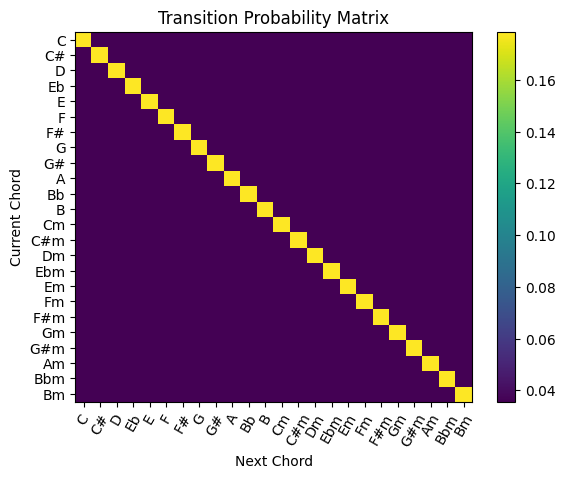

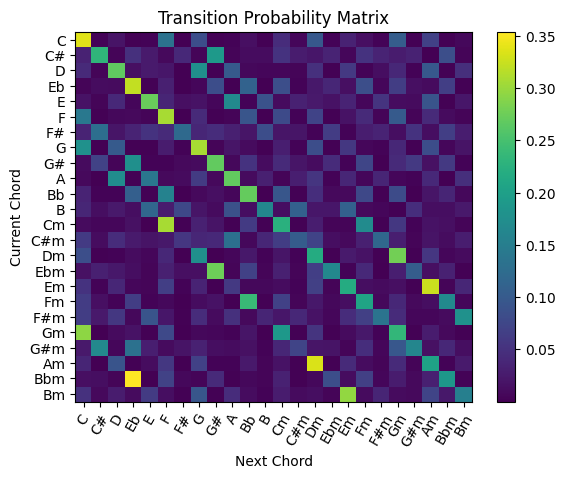

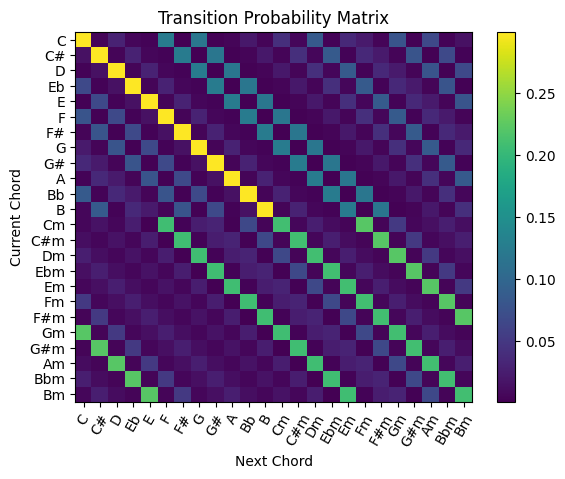

In [391]:
def make_transition_prob_v0():

    A = fmp.make_regular_transition_prob(5.)

    # plot
    plt.figure()
    plt.imshow(A, aspect='auto')
    plt.title("Transition Probability Matrix")
    fmp.chord_template_labels(0)
    fmp.chord_template_labels(1)
    plt.xticks(rotation = 60)
    plt.xlabel("Next Chord")
    plt.ylabel("Current Chord")
    plt.colorbar()
    plt.show()

    return A

def make_transition_prob_v1():
    A = np.zeros((24, 24))

    # sum up occurences
    for song in train_songs:
        measures = list(train_songs[song].keys())
        measures.sort()
        for i in range(len(measures) - 1):
            if i in train_songs[song] and i + 1 in train_songs[song]:
                curr_chord = train_songs[song][measures[i]]['chord']
                next_chord = train_songs[song][measures[i + 1]]['chord']
                curr_idx = chord_to_idx(curr_chord)
                next_idx = chord_to_idx(next_chord)
                A[curr_idx, next_idx] += 1

    # make unlikely transitions still possible
    A[A == 0] = 10

    # normalize
    norm = np.linalg.norm(A, ord=1, axis=1, keepdims=True)
    A = A / norm

    # plot
    plt.figure()
    plt.imshow(A, aspect='auto')
    plt.title("Transition Probability Matrix")
    fmp.chord_template_labels(0)
    fmp.chord_template_labels(1)
    plt.xticks(rotation = 60)
    plt.xlabel("Next Chord")
    plt.ylabel("Current Chord")
    plt.colorbar()
    plt.show()

    return A

def make_transition_prob_v2():
    A = np.zeros((24, 24))

    # sum up occurences
    for song in train_songs:
        measures = list(train_songs[song].keys())
        measures.sort()
        for i in range(len(measures) - 1):
            if i in train_songs[song] and i + 1 in train_songs[song]:
                curr_chord = train_songs[song][measures[i]]['chord']
                next_chord = train_songs[song][measures[i + 1]]['chord']
                curr_idx = chord_to_idx(curr_chord)
                next_idx = chord_to_idx(next_chord)


                shift = curr_idx % 12
                if next_idx < 12:
                    rel_next_idx = (next_idx - shift) % 12
                else:
                    rel_next_idx = (next_idx - shift) % 12 + 12

                # add to transition probability matrix
                if curr_idx < 12:
                    A[0, rel_next_idx] += 1
                else:
                    A[12, rel_next_idx] += 1

    for i in range(1, 12):
        A[i, :] = np.roll(A[0, :], i)

    for i in range(12, 24):
        A[i, :] = np.roll(A[12, :], i-12)

    # make unlikely transitions still possible
    A[A == 0] = 10

    # normalize
    norm = np.linalg.norm(A, ord=1, axis=1, keepdims=True)
    A = A / norm

    # plot
    plt.figure()
    plt.imshow(A, aspect='auto')
    plt.title("Transition Probability Matrix")
    fmp.chord_template_labels(0)
    fmp.chord_template_labels(1)
    plt.xticks(rotation = 60)
    plt.xlabel("Next Chord")
    plt.ylabel("Current Chord")
    plt.colorbar()
    plt.show()

    return A

A0 = make_transition_prob_v0()
A1 = make_transition_prob_v1()
A2 = make_transition_prob_v2()


Step 6. Test the HMM on the testing dataset.

In [370]:
model = hmm.CategoricalHMM(n_components=24)

model.transmat_ = A1
model.startprob_ = np.ones(24) / 24
model.emissionprob_ = B3

scores = []

for song in test_songs:
    observations = []
    for measure in test_songs[song]:
        note = np.zeros(12)
        for n in test_songs[song][measure]['notes']:
            root, dur = n
            note[note_to_idx(root)] += float(dur)**2
        obs = np.argmax(np.dot(chord_templates, note.T)) # compare to chord templates to identify which chord it is
        observations.append(obs)
    _, est = model.decode(np.array(observations).reshape(-1, 1))

    ref = np.array([chord_to_idx(test_songs[song][measure]['chord']) for measure in test_songs[song]])

    # print(f'{song}: {est}')
    # print(f'{song}: {ref}')

    score = np.sum(est == ref) / len(ref)
    scores.append(score)
    # print(f'{song}: {score}')

print(f'average score: {np.mean(scores)}')


average score: 0.2553343801905937


Here's a side-by-side comparison of the trained matrices with the calculated matrices from class.

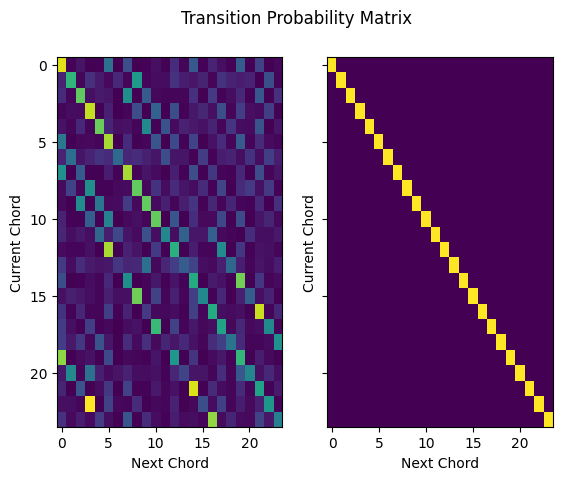

In [344]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.suptitle("Transition Probability Matrix")
ax1.imshow(A1, aspect='auto')
ax1.set_xlabel("Next Chord")
ax1.set_ylabel("Current Chord")
ax2.imshow(A0, aspect='auto')
ax2.set_xlabel("Next Chord")
ax2.set_ylabel("Current Chord")
plt.show()


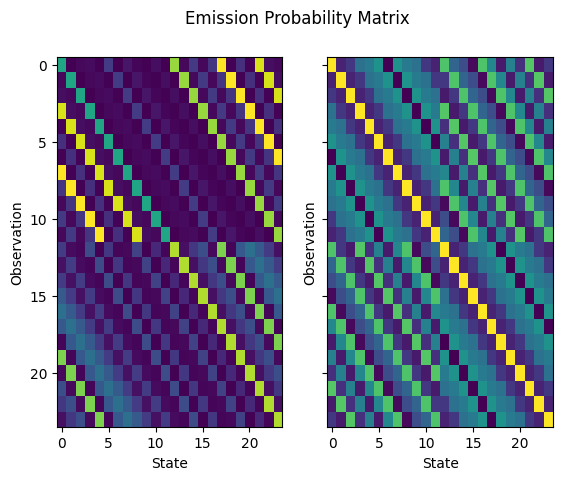

In [345]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.suptitle("Emission Probability Matrix")
ax1.imshow(B2, aspect='auto')
ax1.set_xlabel("State")
ax1.set_ylabel("Observation")
ax2.imshow(B0, aspect='auto')
ax2.set_xlabel("State")
ax2.set_ylabel("Observation")
plt.show()


## Part 2: Process audio input and generate accompaniment
Step 1. Extract fundamental frequencies using CREPE.

In [422]:
# convert a wav file melody to f0 and times
filename = 'simple-trap'
# filename = 'flute-sample'
# filename = 'piano-melody'
filepath = 'audio/' + filename + '.wav'
sr, audio = wavfile.read(filepath)
time, frequency, confidence, activation = crepe.predict(audio, sr, viterbi=True)


/var/folders/_9/93nznkpx1xvfpvf23wvgwfg40000gp/T/ipykernel_4281/3480260639.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, audio = wavfile.read(filepath)


41/41 [==============================] - 7s 172ms/step


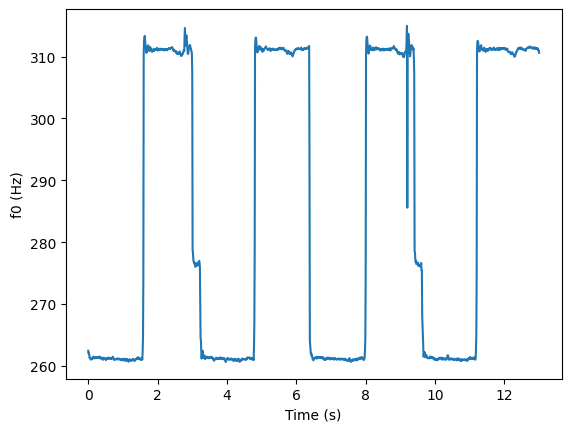

In [423]:
# plot frequency over time
plt.figure()
plt.plot(time, frequency)
plt.xlabel('Time (s)')
plt.ylabel('f0 (Hz)')
plt.show()


Step 2. Estimate when notes change based on peaks in the spectral novelty function.

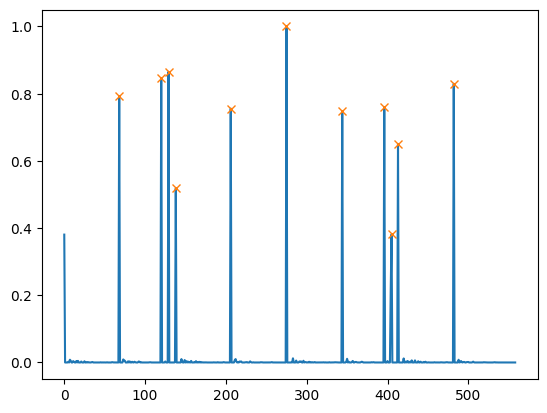

In [424]:
sound = fmp.load_wav(filepath)
fs = 22050
# fmp.plot_and_listen(filepath)

N, H, gamma = 1024, 512, 10

nov = fmp.spectral_novelty(sound, N, H, gamma)
peaks = fmp.find_peaks(nov, 0.2) * H

plt.figure()
plt.plot(nov)
plt.plot(peaks / H, nov[peaks // H], 'x')
plt.show()


Step 3. Estimate the bpm and beats using the dynamic programming strategy from class.

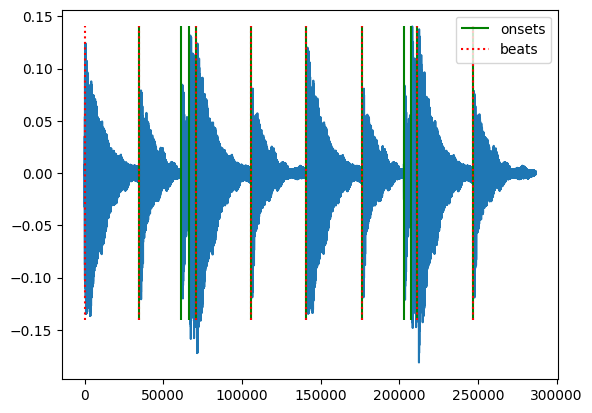

In [425]:
ff = fs / H

bpm = fmp.estimate_bpm(nov, ff, 40, 150)
est_period = int(round(60 * ff / bpm))
beats, _ = fmp.create_dp_beats(nov, est_period, 10) # lambda = 10 for more consistent beat
beat_locations = beats * H # converting to sample location

plt.figure()
plt.plot(sound)
plt.vlines(peaks, -max(sound), max(sound), 'g', label='onsets')
plt.vlines(beat_locations, -max(sound), max(sound), 'r', 'dotted', label='beats')
plt.legend()
plt.show()

click_sound = fmp.load_wav('audio/click.wav')
# clicks = fmp.make_clicks(peaks, len(sound), click_sound)
clicks = fmp.make_clicks(beat_locations, len(sound), click_sound)
click_sound = sound * 0.2 + clicks
ipd.display(ipd.Audio(click_sound, rate=fs))
# soundfile.write('results/' + filename + '-beats.wav', click_sound, fs)


Step 4. Create observation sequence from pitch and beat information.

In [426]:
# Map each peak to a beat
beat_to_peaks = {}
peaks_and_beats_list = []
beat_peak_threshold = 100 # number of samples between beat and peak to be considered the same

for i, beat in enumerate(beat_locations):
    beat_to_peaks[beat] = [beat]
    peaks_and_beats_list.append(beat)
    for peak in peaks:
        if peak > beat_locations[i] and peak < beat_locations[i + 1]:
            if abs(beat_to_peaks[beat][-1]-peak) > beat_peak_threshold:
                beat_to_peaks[beat].append(peak)
                peaks_and_beats_list.append(peak)

# print(beat_to_peaks)
# print(peaks_and_beats_list)

# Calculate note duration for each peak
note_durations = {}
peaks_plus_end = np.append(peaks_and_beats_list, len(sound))
for i in range(len(peaks_and_beats_list)):
    note_durations[peaks_and_beats_list[i]] = peaks_plus_end[i + 1] - peaks_plus_end[i]

# print(note_durations)

time_in_samples = np.array(time) * fs

melody_dictionary = {} # {beat location: [(note location, f0, duration)]}
last_time_ind = 0

for i, beat in enumerate(beat_locations):
    melody_dictionary[beat] = []
    peaks_for_beat = beat_to_peaks[beat]
    for peak in peaks_for_beat:
        start_sample = peak
        end_sample = peak + note_durations[peak]
        sum_f0 = 0
        count_f0 = 0
        while last_time_ind < len(time_in_samples) and time_in_samples[last_time_ind] < end_sample:
            if time_in_samples[last_time_ind] > start_sample:
                sum_f0 += frequency[last_time_ind]
                count_f0 += 1
            last_time_ind += 1
        if count_f0 != 0:
            avg_f0 = sum_f0 / count_f0
            melody_dictionary[beat].append((peak, avg_f0, note_durations[peak]))
# print(melody_dictionary)

melody_cvectors = []
for beat in melody_dictionary:
    chroma_vector = np.zeros(12)
    for note in melody_dictionary[beat]:
        _, f0, duration = note
        pitch = round(fmp.freq_to_pitch(f0)) % 12
        chroma_vector[pitch] += duration**2
    norm = np.linalg.norm(chroma_vector, ord=1)
    melody_cvectors.append(chroma_vector / norm)

melody_observations = []
for cvector in melody_cvectors:
    melody_observations.append(np.argmax(np.dot(chord_templates, cvector)))

print(f'observations for melody: {melody_observations}')


observations for melody: [17, 20, 17, 20, 17, 20, 17, 20]


Step 5. Apply Viterbi algorithm to find the most likely chord state for each beat.

In [427]:
model = hmm.CategoricalHMM(n_components=24)

def invert(A):
    A_inv = np.zeros((24, 24))
    for i in range(24):
        A_inv[i, i] = 1 - A[i, i]
    norm = np.linalg.norm(A_inv, ord=1, axis=1, keepdims=True)
    return A_inv / norm

# inverse = True # doesn't seem to do much
inverse = False

if inverse:
    model.transmat_ = invert(A2)
else:
    model.transmat_ = A2
model.startprob_ = np.ones(24) / 24
model.emissionprob_ = B3

observations = np.array(melody_observations)
obs_column = observations.reshape(-1, 1)

_, est = model.decode(obs_column)

print(f'predicted chord states: {est}')


predicted chord states: [ 0  7 12  8  0  7 12  8]


Step 6. Synthesize accompaniment chords and play original audio with the accompaniment.

In [428]:
est_chords = []
beats_plus_end = np.append(beat_locations, len(sound))
for i in range(len(est)):
    if est[i] < 12: #major
        for c in (0, 4, 7):
            est_chords.append((est[i]+60+c, beat_locations[i] / fs, (beats_plus_end[i+1]-beats_plus_end[i]) / fs))
    else: # minor
        for c in (0, 3, 7):
            est_chords.append((est[i]+60+c, beat_locations[i] / fs, (beats_plus_end[i+1]-beats_plus_end[i]) / fs))

chords_sound = fmp.synthesize_sequence(est_chords, fs)
final_sound = sound[:min(len(sound), len(chords_sound))] + chords_sound[:min(len(sound), len(chords_sound))]

ipd.display(ipd.Audio(final_sound, rate=fs))

soundfile.write('results/' + filename + '-accompaniment-A2-B3.wav', final_sound, fs)
